<a href="https://colab.research.google.com/github/jkaczmarzyk/RedditMentalHealth/blob/main/reddit_mental_health_src.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# install the necessary libraries and perform authorization
import importlib.util
import sys
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [28]:
# set up path to modified data loader
sys.path.append('/content/drive/My Drive/reddit_mental_health')

In [29]:
# faster GPU with Colab Pro
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr 22 19:06:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |   2232MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [30]:
# may have to !pip install transformers
# and then restart notebook

!pip install transformers

In [31]:
# more imports
from pickletools import optimize
from torch.utils.data import DataLoader, RandomSampler
from platform import architecture
import time 
import csv
import pandas as pd
import torch
from transformers import BertTokenizer
import training_utils as tru
import warnings

In [32]:
# ignore warnings
warnings.filterwarnings("ignore")

In [33]:
# packaging up all comments into dictionary
# match comment id with sentiment labels
def get_comments_dic():

    comments_file = '/content/drive/My Drive/reddit_mental_health/nyc/comments.csv' #only set in English

    with open(comments_file,'r') as csvf:
        csv_reader = csv.reader(csvf,delimiter=';')
        data = [row for row in csv_reader]

    comments_dic = {}

    for i,entry in enumerate(data):
        if i != 0:
            comments_dic[entry[0]] = {
                'author':entry[1],
                'body':entry[2],
                'created':time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(entry[3]))),
                'parent':entry[4],
                'thread':entry[5],
                'score':entry[6]
            }

    print(len(comments_dic))

    return comments_dic


# matching up comments with sentiments/emotions labels
def add_scores(comments_dic):
    emotions_file = '/content/drive/My Drive/reddit_mental_health/nyc/emotions.csv'

    with open(emotions_file,'r') as csvf:
        csv_reader = csv.reader(csvf,delimiter=';')
        data = [row for row in csv_reader]

    for entry in data:
        if entry[0] in comments_dic:
            comments_dic[entry[0]]['sad_score'] = entry[6]
            comments_dic[entry[0]]['fear_score'] = entry[4]
            comments_dic[entry[0]]['sadness_normalize'] = entry[15]


    return comments_dic

# gets comments and matches them with labels 
# then puts them into a dataframe
def preprocess_data():
    comments_dic = get_comments_dic()
    comments_dic = add_scores(comments_dic)

    text = []
    sad_labels = []
    fear_labels = []
    sad_norm = []

    for key, val in comments_dic.items():
        text.append(val['body'])
  
        sad_labels.append(val['sadness'])
        fear_labels.append(val['fear_score'])
        sad_norm.append(val['sadness_normalize'])

    df = [text,sad_labels]
    df = pd.DataFrame(df).T
    
    df.columns = ['text','list']

    return df

In [34]:
df = preprocess_data()

95532


In [ ]:
# setting hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

mdl_name = 'google/bert_uncased_L-2_H-128_A-2'
hidden_size = 128

hyperparameters = dict(
    MAX_LENGTH = 300,
    TRAIN_BATCH_SIZE = 100,
    VALID_BATCH_SIZE = 50,
    epochs = 1,
    out_path = './models',
    log_freq=10,
    learn_rate = 1e-06
)

# call BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# randomly sampling (like a shuffle)
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html
df.sample(frac=1)

train_size = 0.8 # 80% of data for training 10% val 10% testing
train_dataset = df.sample(frac=train_size,random_state=42) # randomly shuffling dataset

# half of remaining 20%
validation_size = 0.5
test_val_dataset = df.drop(train_dataset.index).reset_index(drop=True)
validation_dataset = test_val_dataset.sample(frac=validation_size,random_state=42)
test_dataset = test_val_dataset.drop(validation_dataset.index).reset_index(drop=True)

validation_dataset = validation_dataset.reset_index(drop=True)


train_dataset = train_dataset.reset_index(drop=True)

# loading data into custom dataset class
training_set = tru.CustomDataSet(train_dataset, tokenizer, hyperparameters['MAX_LENGTH'])
validation_set = tru.CustomDataSet(validation_dataset, tokenizer, hyperparameters['MAX_LENGTH'])
testing_set = tru.CustomDataSet(test_dataset, tokenizer, hyperparameters['MAX_LENGTH'])

# parameters for training
train_params = {
    'batch_size': hyperparameters['TRAIN_BATCH_SIZE'],
    'shuffle':True,
    'num_workers':0
}

# parameters for testing
validation_params = {
    'batch_size': hyperparameters['VALID_BATCH_SIZE'],
    'shuffle':True,
    'num_workers':0
}

test_params = {
    'batch_size': hyperparameters['VALID_BATCH_SIZE'],
    'shuffle':True,
    'num_workers':0
}


training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **validation_params)
testing_loader = DataLoader(testing_set, **test_params)

# print to check if you're using CPU or GPU


# da modelz
# see here: https://huggingface.co/google/bert_uncased_L-2_H-128_A-2
#  https://huggingface.co/google/bert_uncased_L-12_H-768_A-12
model = tru.BERTClass(mdl_name,hidden_size)
model.to(device)

# da optimizer
optimizer = torch.optim.Adam(params=model.parameters(),
lr=hyperparameters['learn_rate'])

cuda


Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
# training routine
print(device)
for epoch in range(hyperparameters['epochs']):

    param_dic = tru.train(epoch,hyperparameters,device,training_loader,validation_loader,model,optimizer)



  

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


cuda
Checkpoint 0 | F1 : 0.45945945945945943 | Rec : 0.4941860465116279 | Prec : 0.4292929292929293 |
Checkpoint 1 | F1 : 0.4350282485875706 | Rec : 0.5 | Prec : 0.385 |
Checkpoint 2 | F1 : 0.4117647058823529 | Rec : 0.5 | Prec : 0.35 |
Checkpoint 3 | F1 : 0.4444444444444445 | Rec : 0.5 | Prec : 0.4 |
Checkpoint 4 | F1 : 0.4565217391304348 | Rec : 0.5 | Prec : 0.42 |
Checkpoint 5 | F1 : 0.43820224719101125 | Rec : 0.5 | Prec : 0.39 |
Checkpoint 6 | F1 : 0.43820224719101125 | Rec : 0.5 | Prec : 0.39 |
Checkpoint 7 | F1 : 0.4318181818181818 | Rec : 0.5 | Prec : 0.38 |
Checkpoint 8 | F1 : 0.4318181818181818 | Rec : 0.5 | Prec : 0.38 |
Checkpoint 9 | F1 : 0.44751381215469616 | Rec : 0.5 | Prec : 0.405 |
Checkpoint 10 | F1 : 0.41860465116279066 | Rec : 0.5 | Prec : 0.36 |
Checkpoint 11 | F1 : 0.45054945054945056 | Rec : 0.5 | Prec : 0.41 |
Checkpoint 12 | F1 : 0.44134078212290506 | Rec : 0.5 | Prec : 0.395 |
Checkpoint 13 | F1 : 0.41860465116279066 | Rec : 0.5 | Prec : 0.36 |
Checkpoint 14 

In [14]:
import json

# save training metrics to file
x = param_dic['train']['losses']
losses = [l.cpu().detach().numpy().item(0) for l in x]
param_dic['train']['losses'] = losses


x = param_dic['validation']['losses']
losses = [l.cpu().detach().numpy().item(0) for l in x]
param_dic['validation']['losses'] = losses


mdl_metrics = json.dumps(param_dic)

with open('/content/drive/My Drive/reddit_mental_health/tiny_bert_metrics.txt','w') as jfile:
    jfile.write(mdl_metrics)

In [15]:
# save as json
with open('/content/drive/My Drive/reddit_mental_health/tiny_bert_metrics.json','w') as jfile:
    jfile.write(mdl_metrics)

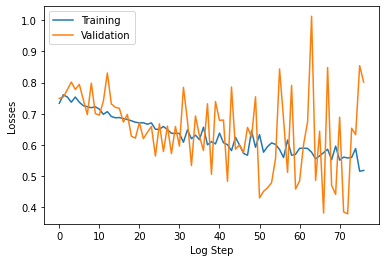

In [18]:
# check model outputs
import matplotlib.pyplot as plt
import numpy as np


p = param_dic['train']['losses']
v = param_dic['validation']['losses']



x = np.array([i for i in range(len(p))])
y = np.array([e for e in p ])
y1 = np.array([e for e in v ])


plt.plot(x,y)
plt.plot(x,y1)

plt.xlabel('Log Step')
plt.ylabel('Losses')
plt.legend(['Training','Validation'])

In [17]:
# save model
import torch
savepath = '/content/drive/My Drive/reddit_mental_health/tinybert.pth'

torch.save(model.state_dict(),savepath)

In [15]:
# model evaluation functions
from sklearn import metrics

def inference(model,test_loader,device):

  model.eval()
  preds = []


  with torch.no_grad():
    for _, data in enumerate(test_loader,0):
        ids = data['ids'].to(device,dtype=torch.long)
        mask = data['mask'].to(device,dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device,dtype=torch.long)
        targets = data['targets'].to(device,dtype=torch.float)
        s = targets.size(dim=0)
        targets = targets.resize(s,1)
        outputs = model(ids,mask,token_type_ids)
        o = torch.sigmoid(outputs).float().cpu().detach().numpy()
        for pred in o:
          preds.append(pred[0])


    return preds


def evaluate_bert_model(filename,test_loader,labels,device,mdl_name,hidden_size):
  bert_model = tru.BERTClass(mdl_name,hidden_size)
  bert_model.load_state_dict(torch.load(filename,map_location=device))
  bert_model.to(device)
  preds = inference(bert_model,test_loader,device)
  prec,rec,thresh = metrics.precision_recall_curve(labels,preds)

  auc = metrics.auc(rec,prec)

  data = [thresh,prec,rec]

  fname = filename.replace('.pth','_prec_rec.csv')

  with open(fname,'w') as csvf:
    writer = csv.writer(csvf,delimiter=',')
    writer.writerows(data)
  
  eval_dic = {
      'Predictions':preds,
      'Precision':prec,
      'Recall':rec,
      'Threshold':thresh,
      'AUC':auc
  }

  return eval_dic


In [16]:
# evaluating the models
name_list = ['/content/drive/My Drive/reddit_mental_health/tiny_bert.pth']
model_dic = {}
labels = []
labs = testing_loader.dataset.targets.values

for l in labs:
  if l > 0.5:
    labels.append(1)
  else:
    labels.append(0)

print(labels)

for i, name in enumerate(name_list):
  eval_dic = evaluate_bert_model(name,testing_loader,labels,device,mdl_name,hidden_size)
  model_dic[name] = eval_dic

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 

Some weights of the model checkpoint at google/bert_uncased_L-8_H-512_A-8 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# plotting results of evaluation (precision & recall)
import matplotlib.pyplot as plt


model_names = list(model_dic.keys())
for name in model_names:
  plt.plot(model_dic[name]['Recall'],model_dic[name]['Precision'])




plt.plot([0,1],[0.5,0.5])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(model_names)

{'train': {'accuracy': [0.79, 0.82, 0.75, 0.79, 0.74, 0.82, 0.71, 0.75, 0.75, 0.8, 0.79, 0.8, 0.8, 0.82, 0.83, 0.76, 0.8, 0.74, 0.77, 0.74, 0.72, 0.8, 0.79, 0.8, 0.78, 0.79, 0.79, 0.74, 0.83, 0.83, 0.72, 0.83, 0.75, 0.86, 0.81, 0.77, 0.81, 0.74, 0.79, 0.82, 0.81, 0.79, 0.82, 0.82, 0.84, 0.8, 0.83, 0.84, 0.75, 0.8, 0.87, 0.83, 0.85, 0.85, 0.86, 0.81, 0.82, 0.86, 0.91, 0.84, 0.87, 0.82, 0.86, 0.83, 0.89, 0.83, 0.87, 0.81, 0.88, 0.85, 0.84, 0.87, 0.76, 0.87, 0.86, 0.83, 0.89], 'recall_macro': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.537037037037037, 0.5689655172413793, 0.6533333333333333, 0.6369463869463869, 0.6831140350877193, 0.7061680427391938, 0.7333333333333334, 0.657859078590786, 0.691468253968254, 0.7160940325497287, 0.6431585292344786, 0.6429539295392954, 0.6666666666666667, 0.6636904761904762, 0.7086247086247086, 0.6625, 0.6566911349520045, 0.6699561403508771, 0.7123015873015872, 0.6695804195804196, 0.6482213438735178, 0.7201927955352613, 0.7525617842073538, 0.6595365418894831, 0.78

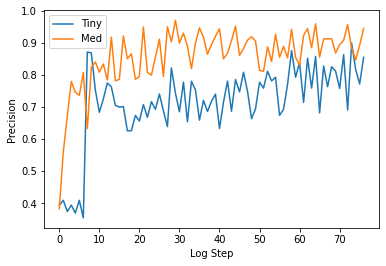

In [26]:
# model comparison
with open('/content/drive/My Drive/reddit_mental_health/tiny_bert_metrics.json','r') as jfile:
  tiny_data = json.load(jfile)

with open('/content/drive/My Drive/reddit_mental_health/med_bert_metrics.json','r') as jfile:
  med_data = json.load(jfile)

print(tiny_data)
print(med_data)

# available metrics
"""'accuracy': accs,
        'recall_macro': recalls_mac,
        'recall_micro': recalls_mic,
        'precisions_mac': precisions_mac,
        'precisions_mic': precisions_mic,
        'f1s_mac': f1s_mac,
        'f1s_mic': f1s_mic,
        'losses': losses
        }"""

p = tiny_data['train']['precisions_mac']
v = med_data['train']['precisions_mac']

x = np.array([i for i in range(len(p))])
y = np.array([e for e in p ])
y1 = np.array([e for e in v ])

plt.plot(x,y)
plt.plot(x,y1)

plt.xlabel('Log Step')
plt.ylabel('Precision')
plt.legend(['Tiny','Med'])